<a href="https://colab.research.google.com/github/Rajarshi07/ML_Projects/blob/master/Copy_of_Deep_Layout_Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [2]:
!pip install layoutparser fvcore layoutparser[ocr] pytesseract pdf2image
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 19.1MB 1.2MB/s 
     |████████████████████████████████| 276kB 32.9MB/s 
     |████████████████████████████████| 4.0MB 48.8MB/s 
     |████████████████████████████████| 753.4MB 21kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200912-cp36-none-any.whl size=43996 sha256=e41f88150453fa14f03505b71b4aca7bbbe970b45d6e8ad3f528854591aa3ba7
  Stored in directory: /root/.cache/pip/wheels/34/41/7b/f0a0b5800bea0474ae553342bde52093fdd5852764463aa2ec
  Created wheel for pytesseract: filename=pytesseract-0.3.6-py2.py3-none-any.whl size=13629 sha256=711f14fa1c2b0400f28f1caacfb0dc647de6463efd747bfbd99e69fc1dc6d750
  Stored in directory: /root/.cache/pip/wheels/ee/71/72/b98430261d849ae631e283dfc7ccb456a3fb2ed2205714b63f
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=45ea07adee729dac4650ea8a2c2ec1674c60af25651eb8f6bd36b15611e72a46
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1

In [1]:
import layoutparser as lp
import pytesseract
import cv2
import pdf2image

## Use Layout Models to detect complex layout 

Cleaning the pdf file by removing header and footer and merging all images into one long image

In [2]:
pages = pdf2image.convert_from_path('sample.pdf')
i = 0
for page in pages:
    page.save('out{}.jpg'.format(i), 'JPEG')
    # Opens a image in RGB mode 
    im = Image.open("out{}.jpg".format(i)) 
    # Setting the points for cropped image to remove header and footer
    left = 0
    top = 150
    right = 1654
    bottom = 2200
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((left, top, right, bottom))
    # Shows the image in image viewer 
    im1.save("out{}.jpg".format(i))
    i+=1


PDFInfoNotInstalledError: ignored

In [21]:
image = cv2.imread("pg1.jpeg")
image = image[..., ::-1] 
cv2.imshow(image)
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [5]:
# model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})

In [42]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [43]:
layout = model.detect(image)
    # Detect the layout of the input image

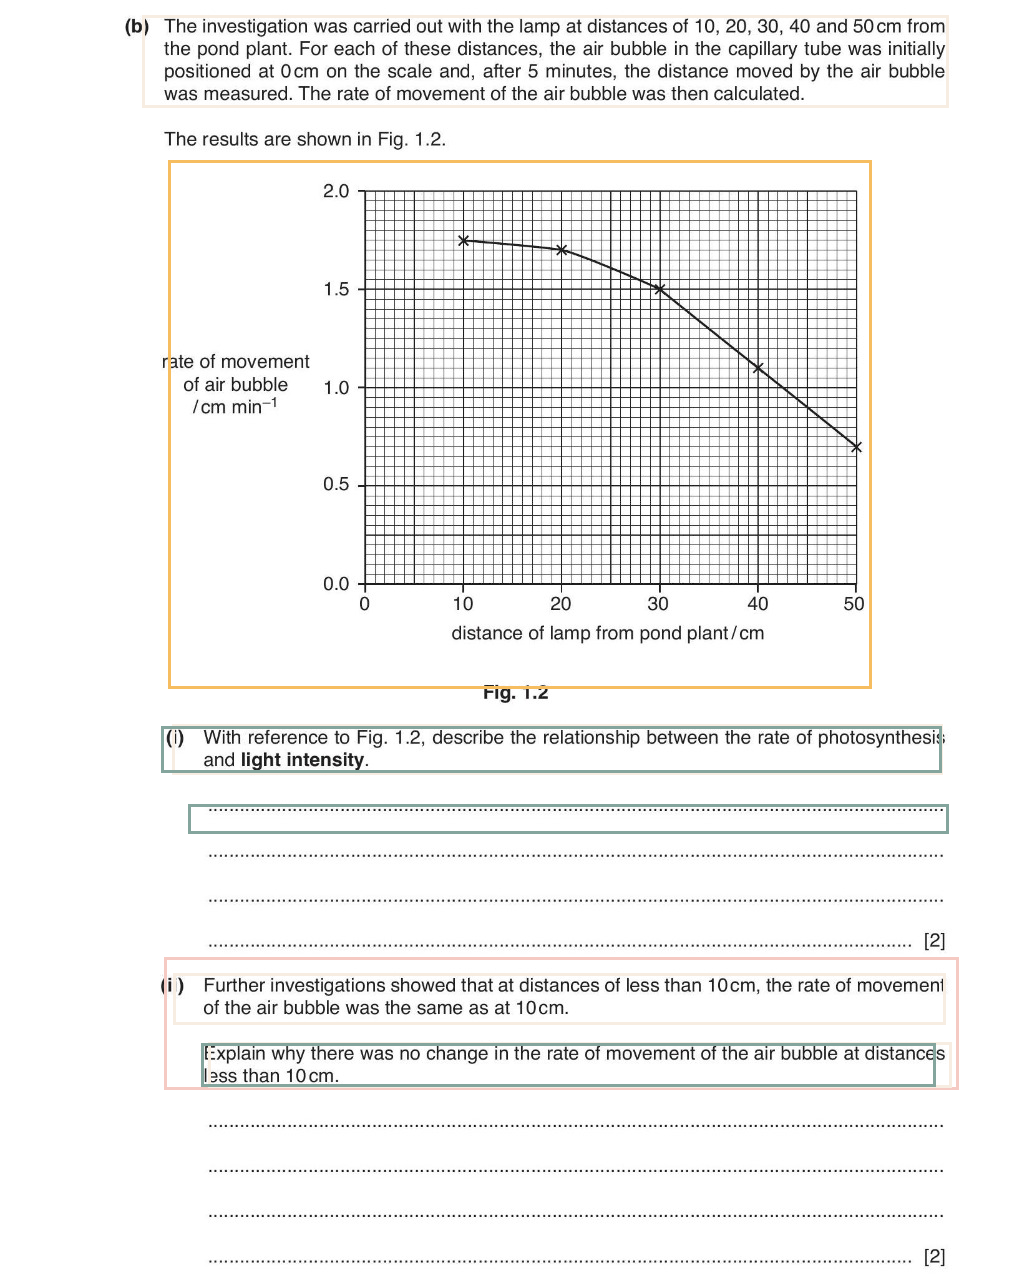

In [48]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

## Check the results from the model 

In [49]:
type(layout)  
for l in layout:
  print(l)       

TextBlock(block=Rectangle(x_1=168.83251953125, y_1=160.4929656982422, x_2=871.4763793945312, y_2=688.3043823242188), text=, id=None, type=Figure, parent=None, next=None, score=0.9963486194610596)
TextBlock(block=Rectangle(x_1=142.09974670410156, y_1=15.373372077941895, x_2=948.404296875, y_2=107.8429183959961), text=, id=None, type=Title, parent=None, next=None, score=0.8891035318374634)
TextBlock(block=Rectangle(x_1=172.209716796875, y_1=724.3070068359375, x_2=942.9129028320312, y_2=774.1570434570312), text=, id=None, type=Title, parent=None, next=None, score=0.8553507924079895)
TextBlock(block=Rectangle(x_1=161.7850341796875, y_1=726.593017578125, x_2=941.4448852539062, y_2=772.6289672851562), text=, id=None, type=Text, parent=None, next=None, score=0.7378794550895691)
TextBlock(block=Rectangle(x_1=164.69290161132812, y_1=957.3663940429688, x_2=958.7933959960938, y_2=1089.6572265625), text=, id=None, type=List, parent=None, next=None, score=0.6320613622665405)
TextBlock(block=Rectang

The `layout` variables is a `Layout` instance, which is inherited from list and supports handy methods for layout processing. 

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text region of specific type:

In [50]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As there could be text region detected inside the figure region, we just drop them:

In [51]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally sort the text regions and assign ids: 

In [52]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

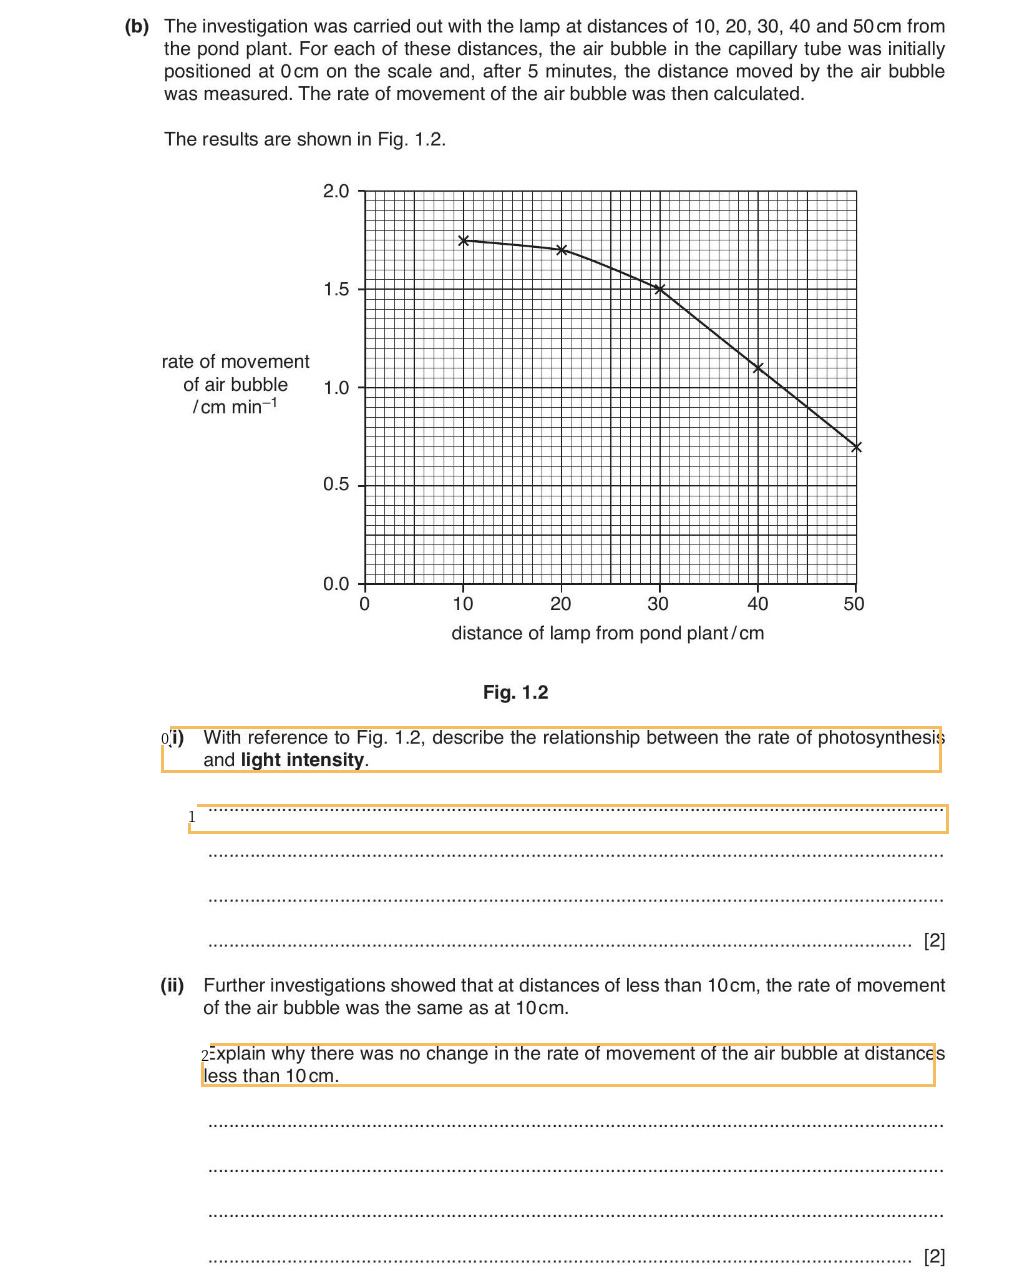

In [53]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetech the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetech the text in the document. 

In [54]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [55]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

TesseractNotFoundError: ignored

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')